<h1><center>API EVALUATION</center></h1>

# 1. Introduction

## Goal
The goal is to test the accuracy of various Face detection web APIs which offer, among other features, emotion recognition.

## Method/Introduction
The web APIs were chosen considering the ones which offered a free plan or free trial.

The programming language used is `Python`. The solutions which offered SDKs which leveraged different programming languages were not considered in this study, as well as the others which did not provide any interface at all to communicate with.

A script is used to send in parallel the whole image set to the various APIs. The raw `json` result and the computed emotions are then stored locally respectively in separate `.json` and `.csv` files for further processing. 
Single snippets have then be created to test both single pictures and the whole image set in order to investigate and compare their accuracy.

## APIs used
The APIs that have been tested are:

**[Amazon Rekognition](https://aws.amazon.com/rekognition/)**<br/>
The detected emotions are `HAPPY | SAD | ANGRY | CONFUSED | DISGUSTED | SURPRISED | CALM | UNKNOWN` and they are associated with a confidence level `[0, 100]`. Only a subset of the previously metioned emotions are returned for each request.

Following are some useful links:
* [api](http://docs.aws.amazon.com/rekognition/latest/dg/faces.html)
* [code sample](http://docs.aws.amazon.com/rekognition/latest/dg/get-started-exercise.html)
* [boto python aws sdk](https://github.com/boto/boto3)
* [emotion param](http://docs.aws.amazon.com/rekognition/latest/dg/API_Emotion.html)

**[Google Cloud Vision](https://cloud.google.com/vision/)**<br/>
The detected emotions are `joy, sorrow, anger, surprise` and they are associated with a confidence level `UNKNOWN, VERY_UNLIKELY, UNLIKELY, POSSIBLE, LIKELY, VERY_LIKELY`.

**[Microsoft Azure Emotion](https://azure.microsoft.com/en-us/services/cognitive-services/emotion/)**<br/>
The detected emotions are `neutral, fear, contempt, disgust, happiness, sadness, surprise` and they are associated with a confidence level `[0,1]`.

**[Face++](https://www.faceplusplus.com)**<br/>
The detected emotions are `fear, anger, neutral, disgust, surprise, happiness` and they are associated with a confidence level `[0, 100]`.

**[Kairos](http://kairos.com/)**<br/>
The detected emotions are `anger, disgust, fear, joy, sadness, surprise` and they are associated with a confidence level `[0, 100]`.

As it appears, not all the APIs are consistent in the emotions detected. To ensure a comparison between the various APIs the output has been uniformed to the following set of emotions: `anger, disgust, fear, joy, neutral, sadness, surprise` associated with a confidence level `[0, 100]`

It is also important to note that the emotions are only a subset of the information retrived from the API. Other features such as facial landmarks, age estimation etc.. may be available.

## Dataset used
The dataset used is the [Cohn-Kanade CK+ dataset](http://www.consortium.ri.cmu.edu/ckagree/) which comprises 6xx pictures, labeled with both _Action Units_ and emotions.

The emotions provided are as follow:
```json
{ 0:'neutral', 1:'anger', 2:'contempt', 3:'disgust', 4:'fear', 5:'happy', 6:'sadness', 7:'surprise' }
```

Since _contempt_ and _disgust_ convey the same facial expression and are difficult to distinguish even by a person, they will be considered as a unique emotion.
So the labeled emotions will be
```json
['neutral', 'anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
```

## Results
....

# 2. The coding approach

## Selecting the images
While the CK+ dataset is composed of images sequence, only the last one, namely the one expressing the highest intensity for the respective emotion was chosen to be sent to each API. This decision was made because the labels are referred to the last image of the sequence and thus it's the most representative.

## Sending the images to the APIs
The process of sending the images to each API listed above is taken care by the `api_query.py` script which leverages `multiprocessing` and `aiohttp` for sending parallel requests and optimize the time needed to complete the requests.

Each API handler has been specifically tuned to the limits imposed by the free account usage of each.

To avoid cluttering the space of this notebook with commented code, the scripts are available below, as attachments:
* [/scripts/api_query.py](/edit/scripts/apis/api_query.py) - Handles the main API communication
* [/scripts/api_structure.py](/edit/scripts/apis/api_structure.py) - Keeps the information and the response structure of each API
* [/scripts/api_keys.py](/edit/scripts/apis/api_keys.py) - Stores the private keys of each API

The response of each API is standardized and stores the confidence of the following set of emotions `['neutral', 'anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']`. The values are stored in the `o_csv/out.csv` file and each response from the api is stored in multiple `o_json/*.json` files.

# 3. Analyzing the results

## Loading the dataset

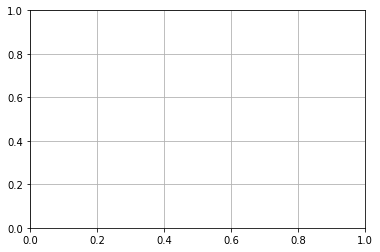

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# setting a default color palette for the charts
sns.set_palette('Set2', n_colors=10)
# set grid in all charts
plt.grid(True)

In [2]:
%matplotlib inline

In [5]:
# let's load the file with the emotins computed by the various APIs
df = pd.read_csv('../scripts/apis/o_csv/out.csv', sep=',', index_col='id')
df.head()

,img_name,source,anger,disgust,fear,joy,neutral,sadness,surprise
id,,,,,,,,,
S087_004_00000012_amazon,S087_004_00000012,amazon,32.352417,3.082138,0.0,0.000000,0.0,3.132832,0.0
S138_008_00000009_amazon,S138_008_00000009,amazon,0.000000,0.000000,0.0,67.143562,0.0,42.504555,0.0
S050_006_00000023_amazon,S050_006_00000023,amazon,0.000000,0.000000,0.0,99.953857,0.0,0.000000,0.0
S060_002_00000026_amazon,S060_002_00000026,amazon,0.000000,0.000000,0.0,98.946846,0.0,0.000000,0.0
S151_002_00000029_amazon,S151_002_00000029,amazon,0.000000,0.000000,0.0,96.703247,0.0,0.000000,0.0


## Analyzing the output of a single image

In [27]:
# let's pick 4 images at random and check the results
nr_rand_img = 4

unique_img = df.img_name.unique()
rand_img = unique_img[np.random.randint(len(unique_img), size=nr_rand_img)]

# if the below solution is chosen
# nr_rand_img = 1
# rand_df = df.loc[df['img_name'] == 'S087_004_00000012']

rand_df = df.loc[df.img_name.isin(rand_img)]
# rand_df.drop('img_name', axis=1, inplace=True)
# sad
rand_df.head()

,img_name,source,anger,disgust,fear,joy,neutral,sadness,surprise
id,,,,,,,,,
S087_004_00000012_amazon,S087_004_00000012,amazon,3.235242e+01,3.082138e+00,0.000000e+00,0.000000,0.000000e+00,3.132832e+00,0.000000e+00
S138_008_00000009_amazon,S138_008_00000009,amazon,0.000000e+00,0.000000e+00,0.000000e+00,67.143562,0.000000e+00,4.250455e+01,0.000000e+00
S060_002_00000026_amazon,S060_002_00000026,amazon,0.000000e+00,0.000000e+00,0.000000e+00,98.946846,0.000000e+00,0.000000e+00,0.000000e+00
S151_002_00000029_amazon,S151_002_00000029,amazon,0.000000e+00,0.000000e+00,0.000000e+00,96.703247,0.000000e+00,0.000000e+00,0.000000e+00
S060_002_00000026_azure,S060_002_00000026,azure,1.863471e-12,1.267722e-11,1.123185e-14,100.000000,1.801516e-10,2.558883e-14,8.855270e-10


Index(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'], dtype='object')
i am here
Index(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'], dtype='object')
i am here
Index(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'], dtype='object')
i am here
Index(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'], dtype='object')
i am here


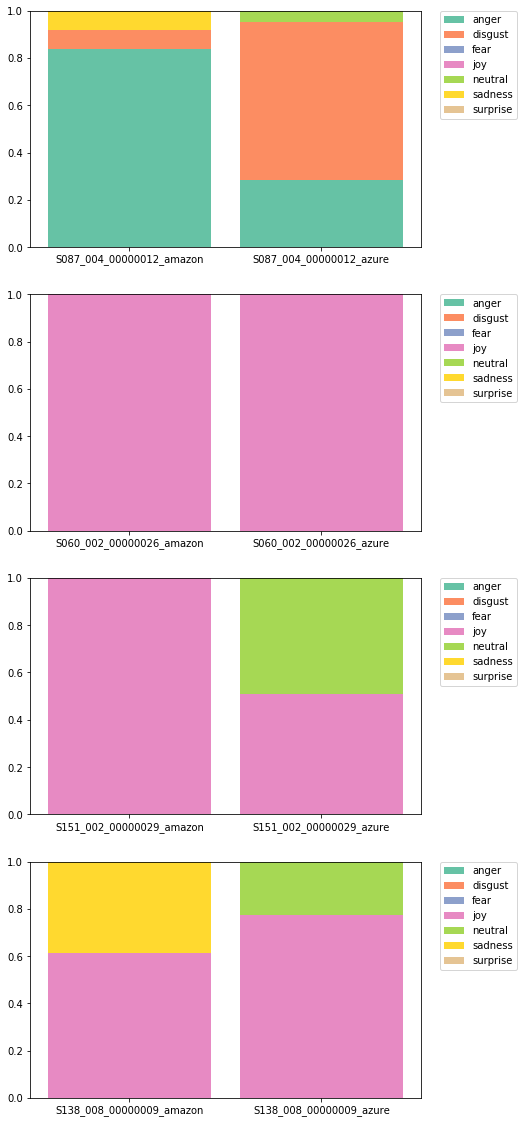

In [61]:
# alfa = 0.3
# np.random.seed(7)
# colors = np.random.rand(7, 4)
# colors[: ,3] = alfa

# function to normalize row in order to make each value a percentage of the row total
def normalize(x):
    return x/x.sum()

# normalize each row so that it sums up to 1
a = rand_df.iloc[:, 2:].apply(normalize, axis=1)

#compare each of the random image above in all the APIs
fig, ax = plt.subplots(nr_rand_img, 1, figsize=(7, 20))
for i in range(nr_rand_img):
    current_img = rand_img[i]
    current_img_df = a.loc[rand_df.img_name == current_img]
    print(current_img_df.columns)
    sum = [0]*current_img_df.shape[0]
    b = []
#     _ = plt.bar(current_img_df.index, current_img_df.anger, 0.85)
    print('i am here')
    for j, e in enumerate(current_img_df.columns):
        temp = ax[i].bar(current_img_df.index.values, current_img_df.iloc[:, j].values, 0.85, bottom=sum)
        b.append(temp)
        sum += current_img_df.iloc[:, j]
    ax[i].set_title('Image {}, true emotion {}'.format())
    ax[i].legend(b, current_img_df.columns, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)


<Container object of 7 artists>

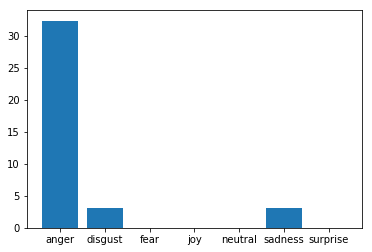

In [12]:
single_image = df.iloc[0, 2:]
plt.bar(single_image.index, single_image)

In [13]:
# stacked barplot per mostrare, per ogni api, le emozioni piu' importanti
# per l'immagine sad devo fare la normalizzazione
sad = df.loc[df['img_name'] == 'S087_004_00000012']
sad.drop('img_name', axis=1, inplace=True)
sad

C:\Users\dask\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,source,anger,disgust,fear,joy,neutral,sadness,surprise
id,,,,,,,,
S087_004_00000012_amazon,amazon,32.352417,3.082138,0.000000,0.000000,0.000000,3.132832,0.000000
S087_004_00000012_azure,azure,27.888310,65.839580,0.000224,0.000036,4.369273,0.192096,0.046082


In [16]:
def normalize(x):
    return x/x.sum()

a = sad.iloc[:, 1:].apply(normalize, axis=1)
a.head()

,anger,disgust,fear,joy,neutral,sadness,surprise
id,,,,,,,
S087_004_00000012_amazon,0.838854,0.079916,0.000000,0.000000e+00,0.000000,0.081230,0.000000
S087_004_00000012_azure,0.283603,0.669540,0.000002,3.655844e-07,0.044432,0.001953,0.000469


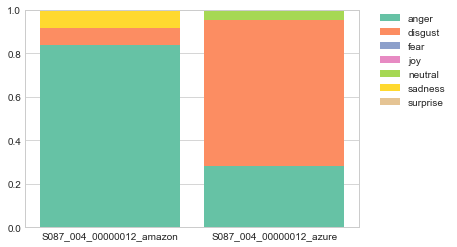

In [51]:
alfa = 0.3
np.random.seed(7)
colors = np.random.rand(7, 4)
colors[: ,3] = alfa

sum = [0]*a.shape[0]
b = []
for i, e in enumerate(a.columns):
    temp = plt.bar(a.index, a.iloc[:, i], 0.85, bottom=sum)
    b.append(temp)
    sum += a.iloc[:, i]
plt.legend(b, a.columns, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)

# COMPARE OUTPUTS

In [179]:
# compare all api outputs with real value to see accuracy
out = pd.read_csv('../o_csv/out.csv', sep=',', index_col='id')
# out = pd.read_csv('../o_csv/out.csv', sep=',')
out.head()

,img_name,source,anger,disgust,fear,joy,neutral,sadness,surprise
id,,,,,,,,,
S087_004_00000012_amazon,S087_004_00000012,amazon,32.352417,3.082138,0.0,0.000000,0.0,3.132832,0.0
S138_008_00000009_amazon,S138_008_00000009,amazon,0.000000,0.000000,0.0,67.143562,0.0,42.504555,0.0
S050_006_00000023_amazon,S050_006_00000023,amazon,0.000000,0.000000,0.0,99.953857,0.0,0.000000,0.0
S060_002_00000026_amazon,S060_002_00000026,amazon,0.000000,0.000000,0.0,98.946846,0.0,0.000000,0.0
S151_002_00000029_amazon,S151_002_00000029,amazon,0.000000,0.000000,0.0,96.703247,0.0,0.000000,0.0


In [181]:
# read labeled dataset keeping only useful columns
label_df = pd.read_csv('./labeled_sample.csv', sep=',', index_col='img_name', usecols=['img_name', 'emotion'])
# temp
label_df.index = label_df.index.map(lambda x: x.strip(' '))
label_df.head()

,emotion
img_name,
S999_003_00000055,4
S087_004_00000012,3
S060_002_00000026,5
S138_008_00000009,2
S151_002_00000029,2


In [182]:
# original
# { 0:'neutral', 1:'anger', 2:'contempt', 3:'disgust', 4:'fear', 5:'happy', 6:'sadness', 7:'surprise' }
emotion_conversion = {
    0:'neutral',
    1:'anger',
    2:'joy',
    3:'disgust',
    4:'fear',
    5:'joy',
    6:'sadness',
    7:'surprise'
}
label_df.emotion = label_df.emotion.apply(lambda x: emotion_conversion[x])
label_df.head()

,emotion
img_name,
S999_003_00000055,fear
S087_004_00000012,disgust
S060_002_00000026,joy
S138_008_00000009,joy
S151_002_00000029,joy


In [183]:
# create dataframe with only the emotion with the highest value and the real emotion
compare_df = pd.DataFrame(columns=['img_name', 'source'], index=out.index)
compare_df.img_name = out.img_name
compare_df.source = out.source
compare_df.head()

,img_name,source
id,,
S087_004_00000012_amazon,S087_004_00000012,amazon
S138_008_00000009_amazon,S138_008_00000009,amazon
S050_006_00000023_amazon,S050_006_00000023,amazon
S060_002_00000026_amazon,S060_002_00000026,amazon
S151_002_00000029_amazon,S151_002_00000029,amazon


In [184]:
def find_index(x):
    m = x.max()
    i = x.tolist().index(m)
    return x.index[i], m

compare_df['computed'], compare_df['confidence'] = zip(*out.iloc[:, 3:].apply(find_index, axis=1))
compare_df.head()

,img_name,source,computed,confidence
id,,,,
S087_004_00000012_amazon,S087_004_00000012,amazon,sadness,3.132832
S138_008_00000009_amazon,S138_008_00000009,amazon,joy,67.143562
S050_006_00000023_amazon,S050_006_00000023,amazon,joy,99.953857
S060_002_00000026_amazon,S060_002_00000026,amazon,joy,98.946846
S151_002_00000029_amazon,S151_002_00000029,amazon,joy,96.703247


In [189]:
# boh = pd.merge(left=compare_df, right=label_df, right_index=True, left_on='img_name', how='left')
# boh = ni.merge(label_df, right_index=True, left_on='img_name', how='outer')
# boh
compare_df_j = compare_df.join(label_df, on='img_name')
compare_df_j.rename(columns={'emotion':'real'}, inplace=True)
compare_df_j.head()

,img_name,source,computed,confidence,real
id,,,,,
S087_004_00000012_amazon,S087_004_00000012,amazon,sadness,3.132832,disgust
S138_008_00000009_amazon,S138_008_00000009,amazon,joy,67.143562,joy
S050_006_00000023_amazon,S050_006_00000023,amazon,joy,99.953857,joy
S060_002_00000026_amazon,S060_002_00000026,amazon,joy,98.946846,joy
S151_002_00000029_amazon,S151_002_00000029,amazon,joy,96.703247,joy


In [214]:
# check whether computed and emotion are equal
compare_df_j['correct'] = compare_df_j.computed == compare_df_j.real
compare_df_j.head()

,img_name,source,computed,confidence,real,correct
id,,,,,,
S087_004_00000012_amazon,S087_004_00000012,amazon,sadness,3.132832,disgust,False
S138_008_00000009_amazon,S138_008_00000009,amazon,joy,67.143562,joy,True
S050_006_00000023_amazon,S050_006_00000023,amazon,joy,99.953857,joy,True
S060_002_00000026_amazon,S060_002_00000026,amazon,joy,98.946846,joy,True
S151_002_00000029_amazon,S151_002_00000029,amazon,joy,96.703247,joy,True


## find correct ones

NameError: name 'compare_df_j' is not defined

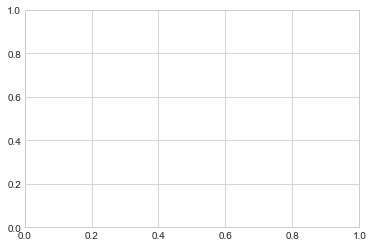

In [47]:
# fare uno scatterplot e colorare di rosso quegli sbagliati e con valore pari alla confidence
# mentre in verde quelli giusti, sempre con il valore della confidence
fig, axes = plt.subplots(1, 1)
sns.set_style("whitegrid")
_ = sns.swarmplot(x='real', y='confidence', hue='correct', palette='Set2', data=compare_df_j)

In [221]:
# count nr of correct ones
correct = compare_df_j.loc[compare_df_j.correct == True].shape[0]
incorrect = compare_df_j.shape[0] - correct
print('There are {} correct and {} incorrect emotions'.format(correct, incorrect))

There are 12 correct and 2 incorrect emotions


## find the most difficult emotions to predict

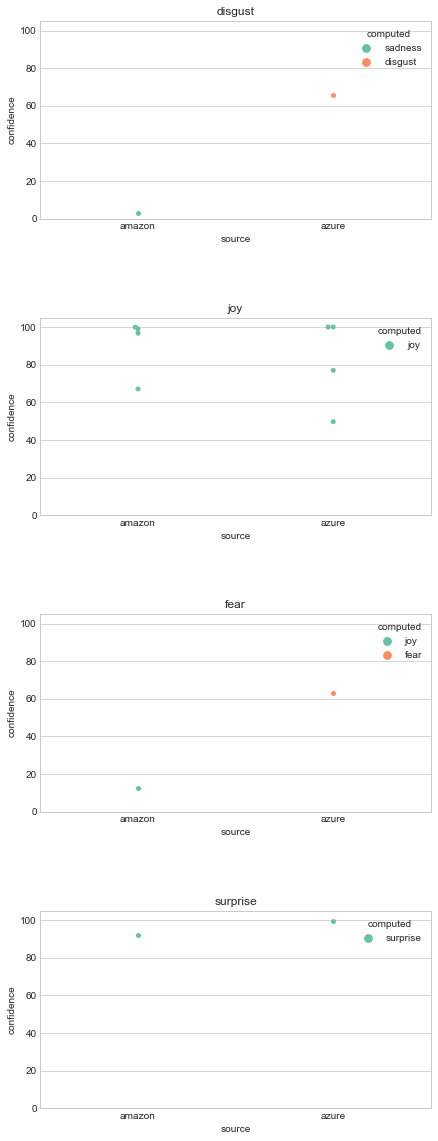

In [251]:
# count the nr of real emotions
emotions_real = compare_df_j.real.unique()
emotions_nr = emotions_real.shape[0]
# for each emotion, build the chart
fix, axes = plt.subplots(emotions_nr, 1, figsize=(7, 20))
# cycle and create all plots
for i in range(emotions_nr):
    _ = sns.swarmplot(x='source', y='confidence', hue='computed', palette='Set2', data=compare_df_j.loc[compare_df_j.real == emotions_real[i]], ax=axes[i])
    _.set_title(emotions_real[i])
    _.set_ylim(0,105)
plt.subplots_adjust(wspace=.5, hspace=.5)

## TRACK EMOTION PROGRESSION FOR A SINGLE API

In [4]:
api = 'amazon'
# get chosen api data
api_data = df.loc[df.source == api].sort_values('img_name')

In [5]:
api_data.iloc[0:3]

,img_name,source,anger,disgust,fear,joy,neutral,sadness,surprise
id,,,,,,,,,
S050_006_00000023_amazon,S050_006_00000023,amazon,0.000000,0.0,0.0,99.953857,0.0,0.0,0.000000
S060_002_00000026_amazon,S060_002_00000026,amazon,0.000000,0.0,0.0,98.946846,0.0,0.0,0.000000
S077_001_00000028_amazon,S077_001_00000028,amazon,2.991277,0.0,0.0,0.000000,0.0,0.0,91.978363


In [6]:
import logging
import multiprocessing
from multiprocessing import Process, Lock


lock = Lock()

def create_logger():
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
 
    fh = logging.FileHandler("process.log")
 
    fmt = '%(asctime)s - %(levelname)s - %(message)s'
    formatter = logging.Formatter(fmt)
    fh.setFormatter(formatter)
 
    logger.addHandler(fh)
    return logger
 
def printer(item):
    """
    Prints out the item that was passed in
    """
    lock.acquire()
    try:
        print(item)
    finally:
        lock.release()
if __name__ == '__main__':
    items = ['tango', 'foxtrot', 10]
    logger = create_logger()
    for item in items:
        p = Process(target=printer, args=(item,))
        p.start()

In [9]:
from multiprocessing import Process, current_process

def doubler(number):
    result = number * 2
    proc_name = current_process().name
    print('{0} doubled to {1} by: {2}'.format(number, result, proc_name))
    
if __name__ == '__main__':
    print('wui')
    numbers = [5, 10, 15, 20, 25]
    procs = []
    proc = Process(target=doubler, args=(5,))
 
    for index, number in enumerate(numbers):
        proc = Process(target=doubler, args=(number,))
        procs.append(proc)
        proc.start()
 
    proc = Process(target=doubler, name='Test', args=(2,))
    proc.start()
    procs.append(proc)
 
    for proc in procs:
        proc.join()

wui


In [ ]:
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import multiprocessing
import logging
# from itertools import repeat

fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[:-1, 1])
ax3 = plt.subplot(gs[-1, 1])

img = mpimg.imread('../img/S050_006_00000023.png')

img = ax1.imshow(img)
chart = ax2.plot(api_data.img_name, api_data.iloc[:, 2:])
line, = ax2.plot([0, 0], [0, 100], '--', linewidth=1, color='grey', zorder=2)
bar  = ax3.bar(api_data.columns[2:], api_data.iloc[0, 2:])

ax2.legend(api_data.iloc[:, 2:].columns, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)

def do_calculation(i):
    print('dentro')
#     ax1.imshow('../img/' + img)
#     line.set_xdata([i, i])
#     for i, b in enumerate(bar):
#         b.set_height(api_data.iloc[3, 2+i])
#     print('done')
#     plt.savefig('./video/' + str(i) + '.jpg')
    return i

def start_process():
    print('Starting', multiprocessing.current_process().name)

if __name__ == '__main__':
    multiprocessing.log_to_stderr(logging.DEBUG)
    print('here')
    frames = api_data.img_name + '.png'
    print(list(frames))
#     print(frames.img_name)
    pool_size = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(
        processes=pool_size,
        initializer=start_process
    )
    pool_outputs = pool.map(do_calculation, list(np.arange(frames.shape[0])))
    pool.close()  # no more tasks
    pool.join()  # wrap up current tasks
#     with multiprocessing.Pool(processes = pool_size) as pool:
#         print(frames.shape[0], list(frames))
#         pool.starmap(do_calculation, zip(np.arange(frames.shape[0]), list(frames)))


here
['S050_006_00000023.png', 'S060_002_00000026.png', 'S077_001_00000028.png', 'S087_004_00000012.png', 'S138_008_00000009.png', 'S151_002_00000029.png', 'S999_003_00000055.png']


In [ ]:
aaa